In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 1. The model, the GAN, and the data are loaded

In [2]:
classifier = load_model("modelo_principal.keras")

In [3]:
df = pd.read_csv("X_filtered.csv")

In [4]:
# Re-definir la función de pérdida personalizada
def adversarial_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(y_pred), y_pred))

# Cargar el modelo indicando la función personalizada
gan = load_model("gan.keras", custom_objects={"adversarial_loss": adversarial_loss})
generator = load_model("generator.keras")

c:\Users\samue\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\samue\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 2. We generate 200,000 samples using the GAN to achieve class balance with the benign traffic

In [5]:
df["Target"].value_counts()

Target
0    1258280
1    1087425
Name: count, dtype: int64

In [6]:
input_dim = 90  # vector aleatorio que usará el generador para crear el ruido
datos_generados = generator.predict(np.random.normal(0, 1, (200000, input_dim)))
datos_generados = pd.DataFrame(datos_generados, columns=df.drop(columns= "Target").columns)
datos_generados["Target"] = 1
datos_generados = datos_generados[df.columns]

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [7]:
df_combined = pd.concat([df, datos_generados], ignore_index=True)
df_combined["Target"].value_counts()

Target
1    1287425
0    1258280
Name: count, dtype: int64

## 3. The original model is retrained

In [8]:
X = df_combined.drop(columns= "Target")
y = df_combined["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [9]:
def build_classification_model(input_shape):

    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.15),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',  # Pérdida para problemas binarios
        metrics=['accuracy']#, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

classifier_reentrenado = build_classification_model((X_train.shape[1],))

callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = classifier_reentrenado.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5000, 
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9850 - loss: 0.0486 - val_accuracy: 0.9979 - val_loss: 0.0067
Epoch 2/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9984 - val_loss: 0.0045
Epoch 3/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9981 - loss: 0.0059 - val_accuracy: 0.9989 - val_loss: 0.0035
Epoch 4/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9991 - val_loss: 0.0030
Epoch 5/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 6/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9989 - loss: 0.0036 - val_accuracy: 0.9991 - val_loss: 0.0029
Epoch 7/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.9993 - val_loss: 0.0024
Epoch 8/5000
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/s

## 4. New data is generated and the model is evaluated

In [10]:
nuevos_datos_generados = generator.predict(np.random.normal(0, 1, (100000, input_dim)))
nuevos_datos_generados = pd.DataFrame(nuevos_datos_generados, columns= X_train.columns)
preds = classifier_reentrenado.predict(nuevos_datos_generados)
predicciones_clases_modelo_reentrenado = (preds > 0.5).astype(int)
pd.DataFrame(predicciones_clases_modelo_reentrenado).value_counts()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 815us/step


0
1    100000
Name: count, dtype: int64


Precisión en test: 99.94%
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 13s 791us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251444
           1       1.00      1.00      1.00    257697

    accuracy                           1.00    509141
   macro avg       1.00      1.00      1.00    509141
weighted avg       1.00      1.00      1.00    509141



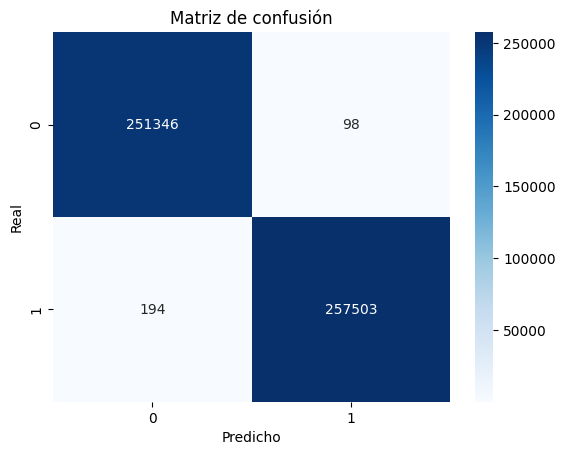

In [11]:
loss, accuracy = classifier_reentrenado.evaluate(X_test, y_test, verbose=0)

print(f"\nPrecisión en test: {accuracy*100:.2f}%")

# Métricas detalladas

y_pred = (classifier_reentrenado.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de confusión')

plt.xlabel('Predicho')

plt.ylabel('Real')

plt.show()

Next, the same generated data is evaluated using the original model, in order to compare its performance before and after the new training process.

In [12]:
preds_modelo_original = classifier.predict(nuevos_datos_generados)
predicciones_clases_primer_modelo = (preds_modelo_original > 0.5).astype(int)
pd.DataFrame(predicciones_clases_primer_modelo).value_counts()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 818us/step


0
0    99966
1       34
Name: count, dtype: int64


Precisión en test: 92.11%
15911/15911 ━━━━━━━━━━━━━━━━━━━━ 15s 965us/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    251444
           1       1.00      0.84      0.92    257697

    accuracy                           0.92    509141
   macro avg       0.93      0.92      0.92    509141
weighted avg       0.93      0.92      0.92    509141



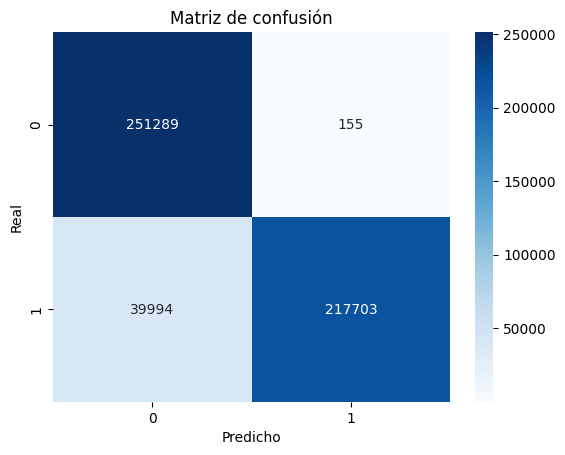

In [13]:
loss, accuracy = classifier.evaluate(X_test, y_test, verbose=0)

print(f"\nPrecisión en test: {accuracy*100:.2f}%")

# Métricas detalladas

y_pred = (classifier.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de confusión')

plt.xlabel('Predicho')

plt.ylabel('Real')

plt.show()

In this result, we observe how the model initially classified most of the data as benign (label 0). However, after retraining with synthetic data, the improved model shows a greater ability to correctly detect the generated samples, avoiding being deceived.

## 6. The retrained model is saved

In [15]:
classifier_reentrenado.save("modelo_reentrenado.keras")